# Test of neural network as a general function approximator

(1000, 2) (1000,)
example:  [ 1.80994154 -0.09515055] -> 0.8763902590128203
number batches:  32
(32, 2) (32,)


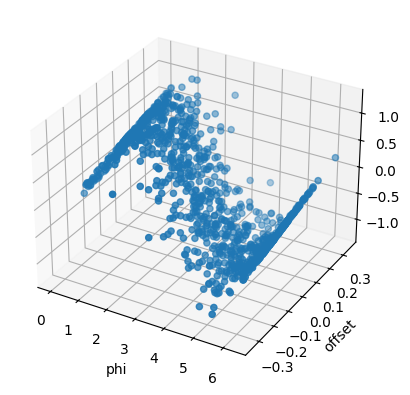

In [1]:
# generate data
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp  # JAX NumPy

def func(x):
    phi, offset = x
    return np.sin(phi) + offset

def generate_data(n=1000):
    phi = np.random.uniform(0, 2 * np.pi, n)
    offset = np.random.normal(0, 0.1, n)
    return np.vstack((phi, offset)).T, func((phi, offset))

xs,ys = generate_data()
print(xs.shape,ys.shape)
print("example: ", xs[1], "->", ys[1])

# create batches
nbatch = 32
# batches = data
batches = []
for i in range(0, len(xs), nbatch):
    batches.append((jnp.array(xs[i:i+nbatch]), jnp.array(ys[i:i+nbatch])))
inputs, targets = batches[0]
print("number batches: ", len(batches))
print(inputs.shape, targets.shape)

# plot data in 3d space
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs[:,0], xs[:,1], ys)
ax.set_xlabel('phi')
ax.set_ylabel('offset')
ax.set_zlabel('y')
plt.show()

In [2]:
# build simple fully-connected deep neural network as function approximator
# using flax
from flax import linen as nn
import jax
from typing import Any, Callable, Sequence
class Model(nn.Module):
    features: Sequence[int]
    
    def setup(self):
        self.layers = [nn.Dense(feat) for feat in self.features]
            
    def __call__(self, x):
        for i, lyr in enumerate(self.layers):
            x = lyr(x)
            if i != len(self.layers) - 1:
                x = nn.tanh(x)
        return x
    
# initialize model
rng = jax.random.PRNGKey(0)
model = Model(features = [64]*2+[1])
dummy_input = jnp.ones((1, 2))
params = model.init(rng, dummy_input)
jax.tree_util.tree_map(lambda x: x.shape, params) # Checking output shapes


{'params': {'layers_0': {'bias': (64,), 'kernel': (2, 64)},
  'layers_1': {'bias': (64,), 'kernel': (64, 64)},
  'layers_2': {'bias': (1,), 'kernel': (64, 1)}}}

In [8]:
from flax.training import train_state  # Useful dataclass to keep train state
import optax      
from tqdm import tqdm

state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=optax.adam(learning_rate=0.01))

# auto-batching
def predict(params, input):
    return model.apply_fn(params, input)
batched_predict = jax.vmap(predict, in_axes=(None, 0))
def loss_fn(params, x, y):
    preds = state.apply_fn(params, x)
    #loss = optax.l2_loss(predictions=preds, targets=y).mean()
    # mse loss
    loss = jnp.mean(jnp.square(preds - y))
    # # Add regularization for each layer
    # for layer_params in params.values():
    #     for param in layer_params.values():
    #         loss += 0.001 * jnp.sum(jnp.square(param['kernel']))  # L2 regularization

    return loss

# Define a training step
@jax.jit
def train_step(state, batch):
    inputs, targets = batch
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params, inputs, targets)
    #grads = jax.grad(loss_fn)(state.params, inputs, targets)
    state = state.apply_gradients(grads=grads)
    return state, loss

# Training loop
epochs = np.arange(20000)
losses = []
for epoch in tqdm(epochs):
    for i in range(len(batches)):
        state, loss = train_step(state, batches[i])
    losses.append(loss)
    #print(f"Epoch {epoch+1}, Loss: {loss}")

100%|██████████| 20000/20000 [02:24<00:00, 138.84it/s]


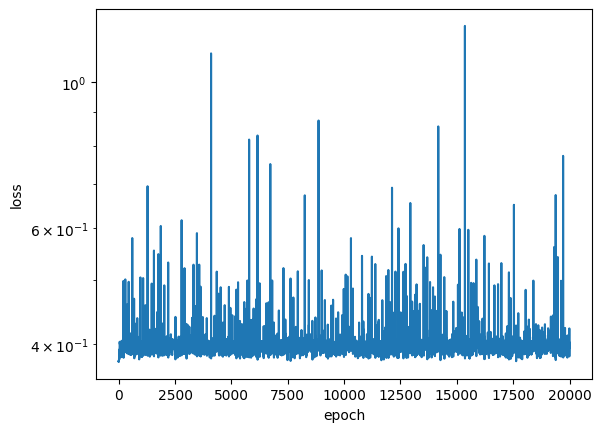

In [9]:
#plot loss
plt.plot(epochs, losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")

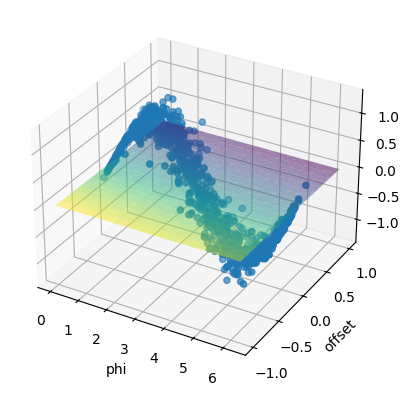

In [10]:
# plot function prediction into previous plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs[:,0], xs[:,1], ys)
ax.set_xlabel('phi')
ax.set_ylabel('offset')
ax.set_zlabel('y')
xcont = np.linspace(0, 2*np.pi, 20)
ycont = np.linspace(-1, 1, 20)
# iterate over xcont and ycont and evaluate prediciton
xs_ = []
pred = []
for x in xcont:
    for y in ycont:
        xs_.append(np.array([[x,y]]))
        pred.append(state.apply_fn(state.params, xs_[-1]))

#plot xs vs pred in 3d plot as mesh
ax.plot_trisurf(np.array(xs_)[:,0,0], np.array(xs_)[:,0,1], np.array(pred)[:,0,0], cmap="viridis", edgecolor="none", alpha=0.5)